# **Red convolucional para clasificar imágenes de medicamentos**
**Curso de Introducción a Machine Learning** </a> <br>
**Autores:** Abraham Tamargo,
Ángela Troncoso, 
Tamara Alonso
    &nbsp;&nbsp;&nbsp; **Última modificación:** 22/11/2021

--------------------------------------------------------------------------
## Índice
1. <a href="#c1"> Instalación de librerías </a> <br>
2. <a href="#c2"> Dataset de partida   </a> <br>
    2.1. <a href="#c21"> Lectura desde Drive</a> <br>
    2.2. <a href="#c22"> Data augmentation  </a>  <br>
3. <a href="#c3t"> Modelos pre entrenados </a> <br>
    3.1. <a href="#c4"> Modelo VGG16 </a> <br>
    3.2. <a href="#c5"> Modelo ResNet50  </a>  <br>
    3.2. <a href="#c6"> Modelo InceptionV3  </a>  <br>
4. <a href="#c6"> Comparación de modelos preentrenados  </a> <br>
5. <a href="#c7"> Aplicación móvil  </a> <br>
6. <a href="#c8"> CLIP </a> <br>
7. <a href="#c9"> Conclusiones y trabajo futuro </a> <br>


## 1. Instalación de librerías <a name="c1"> </a>
Se importan los paquetes de datos que serán necesarios durante la ejecución de la primera parte del notebook. 

In [ ]:
#Importar paquetes de datos
import tensorflow as tf

from tensorflow import Tensor
from tensorflow.keras.models                import Sequential, Model
from tensorflow.keras.preprocessing.image   import ImageDataGenerator
from tensorflow.keras.utils                 import to_categorical
from tensorflow.keras.optimizers            import SGD,Adam
from tensorflow.keras.layers                import *
from tensorflow.keras.applications.vgg16    import preprocess_input
from tensorflow.keras.preprocessing         import image



from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np

## 2. Dataset de partida <a name="c2"> </a>

### 2.1. Lectura desde Drive <a name="c21"> </a>
Primero se conecta con Drive, donde están alojados los archivos

In [ ]:
#Importar imágenes desde Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Se lee la carpeta en cuestión. 

In [ ]:
import os
mainDIR = os.listdir('/content/drive/MyDrive/Proyecto/data set')

print(mainDIR)

['Train', 'Test']


A continuación se crea el objeto generador, que genera el dataset de imágenes para entrenar los modelos de Deep Learning a partir de las carpetas leídas. 

In [ ]:
# Creamos el objeto generador.
im_gen = ImageDataGenerator(rescale=1/255.)

#Y lo añadimos en dos carpetas
train = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory('/content/drive/MyDrive/Proyecto/data set/Train/',target_size=(224, 224))
test  = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory('/content/drive/MyDrive/Proyecto/data set/Test/',target_size=(224,224))

Found 100 images belonging to 10 classes.
Found 10 images belonging to 10 classes.


In [ ]:
next(train)[0].shape

(32, 224, 224, 3)

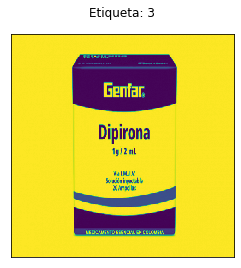

In [ ]:
# Recibo imágenes 
batchX, batchY = next(train)

# Visualizamos las imágenes.
idx = 2
plt.matshow(batchX[idx, :, :, 0])
plt.xticks([])
plt.yticks([])
plt.title("Etiqueta: " + str(np.argmax(batchY[idx])))
plt.show()

### 2.2. Data augmentation <a name="c21"> </a>
El dataset de partida no contiene gran cantidad de datos. Por ello, para que el modelo sea más robusto, se lleva a cabo un proceso de aumento de datos, creando distorsión sobre los datos de partida. 

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions# Generador de imágenes de entrenamiento.

# Generador de imágenes de entrenamiento.
train_gen = ImageDataGenerator(width_shift_range =0.25,
                              height_shift_range=0.25,
                              rotation_range=90,
                              zoom_range=0.2,
                              shear_range=0.2,
                              horizontal_flip=True,
                              preprocessing_function=preprocess_input).flow_from_directory('/content/drive/MyDrive/Proyecto/data set/Train/',target_size=(224,224))


# Generador de imágenes de pruebas.
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory('/content/drive/MyDrive/Proyecto/data set/Test/',target_size=(224,224))

Found 100 images belonging to 10 classes.
Found 10 images belonging to 10 classes.


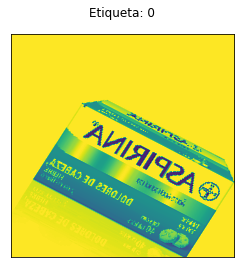

In [ ]:
#Visualizamos la imagen con data augmentation

# Recibo imágenes del generador (alguno de los que he creado)
batchX, batchY = next(train_gen)

# Visualizamos las imágenes.
idx = 2
plt.matshow(batchX[idx, :, :, 0])
plt.xticks([])
plt.yticks([])
plt.title("Etiqueta: " + str(np.argmax(batchY[idx])))
plt.show()

## 3. Modelos pre entrenados <a name="c3t"> </a>

### 3.1 Modelo VGG16 <a name="c3"> </a>
Utilizamos este modelo preentrenado de red neuronal convolucional visto en clase.  

In [ ]:
from tensorflow.keras.applications.vgg16 import preprocess_input

#Paso 1. Generador de imágenes
# Generador de imágenes de entrenamiento.
train_gen = ImageDataGenerator(width_shift_range =0.25,
                              height_shift_range=0.25,
                              rotation_range=90,
                              zoom_range=0.2,
                              shear_range=0.2,
                              horizontal_flip=True,
                              preprocessing_function=preprocess_input).flow_from_directory('/content/drive/MyDrive/Proyecto/data set/Train/',target_size=(224,224))


#Generador de imágenes de pruebas.
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory('/content/drive/MyDrive/Proyecto/data set/Test/',target_size=(224,224))

Found 100 images belonging to 10 classes.
Found 10 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

#Paso 2. Importar el modelo VGG16 pre entrenado

vgg16 = VGG16(input_shape=(224,224,3), include_top=False, weights="imagenet")
vgg16.trainable = False  


# Paso 3. Crear a nuestro modelo.
model = Sequential()

model.add(vgg16)
model.add(Flatten())
model.add(Dense(256, activation='relu'))  #meter esta capa no mejora mucho/nada el modelo
model.add(Dropout(.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(.2))
model.add(Dense(10,  activation='softmax'))

# Paso 4. Entrenar al modelo.
model.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['acc'])

model.fit(train_gen, validation_data=test_gen, epochs=10)

Epoch 1/10
4/4 [==============================] - 58s 13s/step - loss: 12.7467 - acc: 0.0700 - val_loss: 7.7476 - val_acc: 0.1000
Epoch 2/10
4/4 [==============================] - 57s 18s/step - loss: 10.9208 - acc: 0.1000 - val_loss: 6.9695 - val_acc: 0.1000
Epoch 3/10
4/4 [==============================] - 57s 13s/step - loss: 10.2589 - acc: 0.1000 - val_loss: 6.3424 - val_acc: 0.1000
Epoch 4/10
4/4 [==============================] - 57s 18s/step - loss: 9.6851 - acc: 0.1200 - val_loss: 5.8528 - val_acc: 0.0000e+00
Epoch 5/10
4/4 [==============================] - 57s 18s/step - loss: 9.7920 - acc: 0.0800 - val_loss: 5.4903 - val_acc: 0.0000e+00
Epoch 6/10
4/4 [==============================] - 58s 14s/step - loss: 8.8425 - acc: 0.1500 - val_loss: 5.1806 - val_acc: 0.0000e+00
Epoch 7/10
4/4 [==============================] - 57s 13s/step - loss: 9.0876 - acc: 0.0900 - val_loss: 4.9257 - val_acc: 0.0000e+00
Epoch 8/10
4/4 [==============================] - 57s 13s/step - loss: 8.4386 

Los resultados de entrenamiento de este modelo son bastante malos, con un accuracy inferior a 0.2

### 3.2 Modelo ResNet <a name="c4"> </a>

Ahora se aplica otro modelo preentrenado, buscando conseguir unos resultados mejores. 
Es necesario utilizar un generador de imágenes para cada modelo ya que cada uno tiene su propia función de preprocesado (preprocessing_input).

In [ ]:
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
#Paso 1. Generador de imágenes
# Generador de imágenes de entrenamiento.
train_gen = ImageDataGenerator(width_shift_range =0.25,
                              height_shift_range=0.25,
                              rotation_range=90,
                              zoom_range=0.2,
                              shear_range=0.2,
                              horizontal_flip=True,
                              preprocessing_function=preprocess_input).flow_from_directory('/content/drive/MyDrive/Proyecto/data set/Train/',target_size=(224,224))


# Generador de imágenes de pruebas.
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory('/content/drive/MyDrive/Proyecto/data set/Test/',target_size=(224,224))

Found 100 images belonging to 10 classes.
Found 10 images belonging to 10 classes.


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50

#Paso 2. Importar el modelo ResNet pre entrenado
model_ResNet50= ResNet50(include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(224,224,3), pooling=None, classes=10)

model_ResNet50.trainable = False  


# Paso 3. Crear a nuestro modelo.
model2 = Sequential()

model2.add(model_ResNet50)
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))  #meter esta capa no mejora mucho/nada el modelo
model2.add(Dropout(.2))
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(.2))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(.2))
model2.add(Dense(10,  activation='softmax'))

# Paso 4. Entrenar al modelo.
model2.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['acc'])

model2.fit(train_gen, validation_data=test_gen, epochs=10)

94781440/94765736 [==============================] - 1s 0us/step
Epoch 1/10
4/4 [==============================] - 24s 5s/step - loss: 3.8024 - acc: 0.0500 - val_loss: 2.2684 - val_acc: 0.1000
Epoch 2/10
4/4 [==============================] - 20s 6s/step - loss: 3.3015 - acc: 0.0700 - val_loss: 2.2700 - val_acc: 0.1000
Epoch 3/10
4/4 [==============================] - 20s 6s/step - loss: 2.9411 - acc: 0.0600 - val_loss: 2.3300 - val_acc: 0.1000
Epoch 4/10
4/4 [==============================] - 20s 6s/step - loss: 2.8618 - acc: 0.1100 - val_loss: 2.3823 - val_acc: 0.1000
Epoch 5/10
4/4 [==============================] - 20s 4s/step - loss: 2.7740 - acc: 0.1000 - val_loss: 2.4212 - val_acc: 0.1000
Epoch 6/10
4/4 [==============================] - 20s 5s/step - loss: 2.6667 - acc: 0.1100 - val_loss: 2.3930 - val_acc: 0.1000
Epoch 7/10
4/4 [==============================] - 20s 4s/step - loss: 2.5505 - acc: 0.1700 - val_loss: 2.3581 - val_acc: 0.0000e+00
Epoch 8/10
4/4 [===================

Los resultados no mejoran los del modelo anterior. 

### 3.3 Modelo InceptionV3 <a name="c5"> </a>

Probamos con otro modelo preentrenado. 

In [ ]:
from keras.applications.inception_v3 import preprocess_input

#Paso 1. Generador de imágenes
# Generador de imágenes de entrenamiento.
train_gen = ImageDataGenerator(width_shift_range =0.25,
                              height_shift_range=0.25,
                              rotation_range=90,
                              zoom_range=0.2,
                              shear_range=0.2,
                              horizontal_flip=True,
                              preprocessing_function=preprocess_input).flow_from_directory('/content/drive/MyDrive/Proyecto/data set/Train/',target_size=(224,224))

# Generador de imágenes de pruebas.
test_gen = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory('/content/drive/MyDrive/Proyecto/data set/Test/',target_size=(224,224))

Found 100 images belonging to 10 classes.
Found 10 images belonging to 10 classes.


In [ ]:
from keras.applications.inception_v3 import InceptionV3

#Paso 2. Importar el modelo inceptionv3 pre entrenado
model_inceptionv3=InceptionV3(include_top=False, weights='imagenet', input_tensor=None,
    input_shape=(224,224,3), pooling=None, classes=10)

model_inceptionv3.trainable = False  


# Paso 3. Crear a nuestro modelo.
model3 = Sequential()

model3.add(model_inceptionv3)
model3.add(Flatten())
model3.add(Dense(256, activation='relu'))  #meter esta capa no mejora mucho/nada el modelo
model3.add(Dropout(.2))
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(.2))
model3.add(Dense(64, activation='relu'))
model3.add(Dropout(.2))
model3.add(Dense(10,  activation='softmax'))

# Paso 4. Entrenar al modelo.
model3.compile(optimizer=Adam(learning_rate=0.00001),
              loss='categorical_crossentropy',
              metrics=['acc'])

model3.fit(train_gen, validation_data=test_gen, epochs=10)

87924736/87910968 [==============================] - 1s 0us/step
Epoch 1/10
4/4 [==============================] - 20s 5s/step - loss: 2.8816 - acc: 0.1300 - val_loss: 2.3633 - val_acc: 0.1000
Epoch 2/10
4/4 [==============================] - 14s 3s/step - loss: 2.7008 - acc: 0.1100 - val_loss: 2.2884 - val_acc: 0.2000
Epoch 3/10
4/4 [==============================] - 16s 4s/step - loss: 2.4671 - acc: 0.2000 - val_loss: 2.2863 - val_acc: 0.2000
Epoch 4/10
4/4 [==============================] - 16s 4s/step - loss: 2.4352 - acc: 0.1100 - val_loss: 2.2709 - val_acc: 0.2000
Epoch 5/10
4/4 [==============================] - 14s 3s/step - loss: 2.3055 - acc: 0.2100 - val_loss: 2.2595 - val_acc: 0.1000
Epoch 6/10
4/4 [==============================] - 14s 3s/step - loss: 2.4471 - acc: 0.1300 - val_loss: 2.2423 - val_acc: 0.2000
Epoch 7/10
4/4 [==============================] - 16s 4s/step - loss: 2.3471 - acc: 0.1300 - val_loss: 2.2393 - val_acc: 0.1000
Epoch 8/10
4/4 [=======================

## 4. Comparación de los modelos preentrenados <a name="c6"> </a>

Como hemos visto, los modelos preentrenados no obtienen unos resultados satisfactorios. Las gráficas siguientes comparan los resultados obtenidos por cada uno de ellos para las métricas que hemos empleado (accuract, loss, validation accuracy y validation loss). 

In [ ]:
#Averiguamos las keys para obtener las métricas
model.history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

In [ ]:
#Las obtenemos para cada uno de los modelos
#VGG16
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

#RESNET50
acc2 = model2.history.history['acc']
val_acc2 = model2.history.history['val_acc']
loss2 = model2.history.history['loss']
val_loss2 = model2.history.history['val_loss']

#INCEPTIONV3
acc3 = model3.history.history['acc']
val_acc3 = model3.history.history['val_acc']
loss3 = model3.history.history['loss']
val_loss3 = model3.history.history['val_loss']

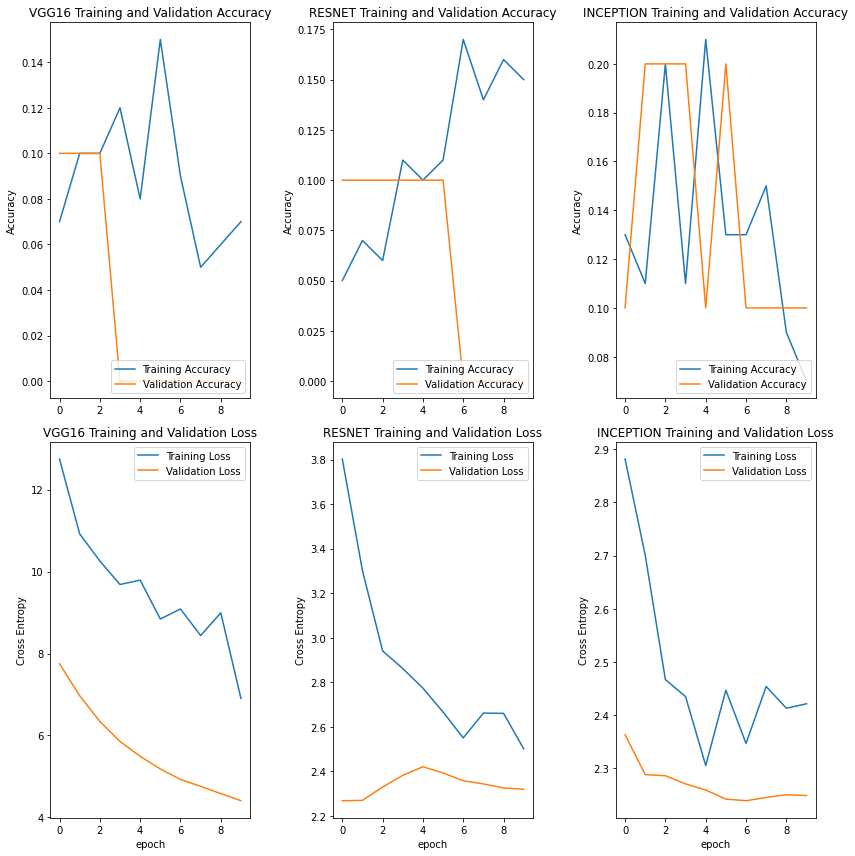

In [ ]:
#Representamos gráficamente
plt.figure(figsize=(12, 12))

plt.subplot(2, 3, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('VGG16 Training and Validation Accuracy')

plt.subplot(2, 3, 4)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('VGG16 Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(2, 3, 2)
plt.plot(acc2, label='Training Accuracy')
plt.plot(val_acc2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('RESNET Training and Validation Accuracy')

plt.subplot(2, 3, 5)
plt.plot(loss2, label='Training Loss')
plt.plot(val_loss2, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('RESNET Training and Validation Loss')
plt.xlabel('epoch')

plt.subplot(2, 3, 3)
plt.plot(acc3, label='Training Accuracy')
plt.plot(val_acc3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('INCEPTION Training and Validation Accuracy')

plt.subplot(2, 3, 6)
plt.plot(loss3, label='Training Loss')
plt.plot(val_loss3, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('INCEPTION Training and Validation Loss')
plt.xlabel('epoch')

plt.tight_layout()
plt.show()

Creemos que la mala clasificación de estos modelos se debe a que existen gran cantidad de diferentes cajas de un mismo medicamento, distribuido por diferentes fabricantes. Así, podemos tener dos cajas de medicinas diferentes que se asemejen más entre sí que si fuesen del mismo medicamento. 
Por ello, creemos que la mejor forma para que el modelo sea capaz de recoonocer de qué medicina se trata sea "leyendo" el nombre en la caja. 

## 5. Aplicación móvil <a name="c7"> </a>

Para facilitar la usabilidad de nuestro proyecto, pensamos en incluir el modelo de clasificación de medicamentos en una aplicación móvil. 
Para ello, nos basamos en el proyecto de reconocimiento de flores utilizando Tensow Flow Lite y Android (https://codelabs.developers.google.com/codelabs/recognize-flowers-with-tensorflow-on-android/#0).

Para ello es necesario exportar el modelo a TensorFlow Lite para poder introducirlo en el código de la app móvil.

A modo de prueba, lo hacemos con el modelo X, que ha sido el que ha obtenido unos resultados levemente mejores de entre los modelos preentrenados utilizados.

In [ ]:
#Lo guardamos en el formato adecuado
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

#Y lo descargamos 
from google.colab import files

files.download('model.tflite')

## 6. Usando CLIP <a name="c8"> </a>
Como se ha comprobado, los modelos anteriores no obtenían unos resultados demasiado buenos. 
CLIP es un modelo novedoso presentado dentro del proyecto Hugging Face (https://huggingface.co/transformers/) que usa técnicas de NLP y de Deep Learning para reconocer imágenes según su descripción. 

Utilizamos su modelo preentrenado para el problema que nos ocupa. 

In [ ]:
#Si la librería no está instalada, descomenta esta línea y ejecútala
#!pip install transformers

     |████████████████████████████████| 3.1 MB 4.3 MB/s 
     |████████████████████████████████| 895 kB 37.8 MB/s 
     |████████████████████████████████| 596 kB 48.3 MB/s 
     |████████████████████████████████| 59 kB 7.0 MB/s 
     |████████████████████████████████| 3.3 MB 41.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


Cargamos e importamos el modelo. 

In [ ]:
from PIL import Image
import requests

from transformers import CLIPProcessor, CLIPModel

model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")  #carga parámetros del modelo preentrenado
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")  #forma de preprocesar las imágenes

#descripciones de las imágenes
#el modelo valida la similitud entre estas descripciones y las imágenes
labels= ["Dolalgial","Espirolactona", "Ibuprofeno","Indometacina","Hidroclotiazida","Furosemida","Dipirona",
                         "Diazepam", "Clortalidona", "Aspirina", "Paracetamol"]

Downloading:   0%|          | 0.00/3.89k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/577M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/316 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/842k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/512k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/568 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.42M [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


El modelo recibe las imágenes de una en una. Hacemos una prueba para ver cómo clasifica distintos medicamentos, usando URLs de imágenes. Es posible saber con qué grado de probabilidad cataloga a cada imagen. 

https://thumbs.dreamstime.com/b/caja-y-tabletas-de-la-droga-aspirina-111729162.jpg
Aspirina


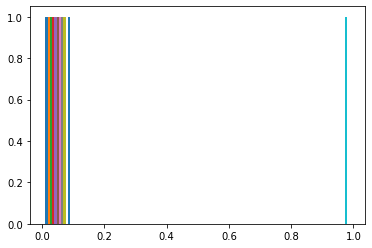

https://www.farmaciaevacontreras.com/wp-content/uploads/2020/12/Paracetamol-Normon-500-mg-20-Comprimidos.jpg
Paracetamol


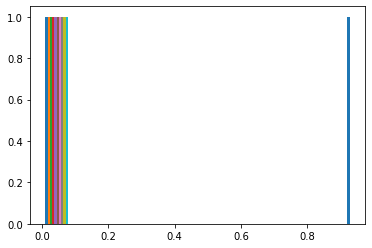

https://res.cloudinary.com/prixz/image/upload/d_default_product_txh9zg.svg,w_500,q_auto/items/7501384502447.jpg
Diazepam


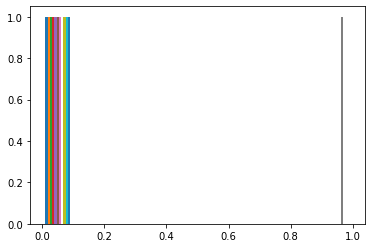

['Dolalgial', 'Espirolactona', 'Ibuprofeno', 'Indometacina', 'Hidroclotiazida', 'Furosemida', 'Dipirona', 'Diazepam', 'Clortalidona', 'Aspirina', 'Paracetamol']


In [ ]:
from PIL import Image
import requests

imagenes = [
  'https://thumbs.dreamstime.com/b/caja-y-tabletas-de-la-droga-aspirina-111729162.jpg',
  'https://www.farmaciaevacontreras.com/wp-content/uploads/2020/12/Paracetamol-Normon-500-mg-20-Comprimidos.jpg',
  'https://res.cloudinary.com/prixz/image/upload/d_default_product_txh9zg.svg,w_500,q_auto/items/7501384502447.jpg']

for url in imagenes: 
  image = Image.open(requests.get(url, stream=True).raw) 
  inputs = processor(text=labels,
                   images=image, return_tensors="pt", padding=True)
  outputs = model(**inputs)
  logits_per_image = outputs.logits_per_image # grado de similitud entre texto e imagen
  probs = logits_per_image.softmax(dim=1) # probabilidad de cada una de ellas
  print(url)
  i= np.argmax(probs.detach().numpy())
  print(labels[i])
  plt.hist(probs.detach().numpy())
  plt.show()

print(labels)

Clasifica correctamente las imágenes probadas, con bastante seguridad. 

De cara a su usabilidad, ya que el usuario no tendrá una URL con la imagen de la caja, sino la caja en sí, se implementa la posibilidad de capturar la imagen con nuestra webcam. 

Para conectar el notebook con la webcam es necesario utilizar el siguiente código. 

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


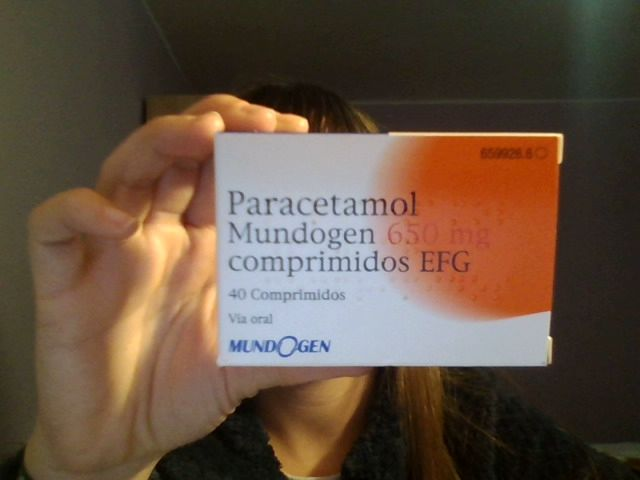

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Y aplicamos el modelo. 

In [ ]:
from PIL import Image
import requests

image = Image.open(filename)

inputs = processor(text=labels,
                   images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # grado de similitud entre texto e imagen
probs = logits_per_image.softmax(dim=1) # probabilidad de cada una de ellas

Y comprobamos la etiqueta asignada por el modelo. 

In [ ]:
i= np.argmax(probs.detach().numpy())
labels[i]

'Paracetamol'

## 7. Conclusiones y trabajo futuro <a name="c9"> </a>

Los modelos de redes neuronales no son óptimos para el reconocimiento de medicamentos debido a la diversidad de cajas de medicamento existentes para cada tipo de medicamento. Por ello, los resultados obtenidos no permiten la clasificación con la suficiente precisión. 

En base a esto probamos el modelo CLIP (Contrastive Language-Image Pre-training) dentro del proyecto Hugging Face que usa técnicas de NLP (Natural Lenguage Processing) y de Deep Learning para reconocer imágenes según su descripción.
Este modelo mostó alta precisión (1.0 de accuracy), aunque no ha sido probado con gran variedad de cajas, y permite la correcta clasificación de los medicamentos a partir de imágenes obtenidas mediante fotos (url) y webcam.

